# Raster data handling with Python

**Authors:** Jan Verbesselt, Jorge Mendes de Jesus, Aldo Bergsma, Dainius Masiliunas, David Swinkels, Judith Verstegen, Corné Vreugdenhil, Arno Timmer

*Date generated: 2025-08-28*

<font size="6">[WUR Geoscripting](https://geoscripting-wur.github.io/)</font> <img src="https://www.wur.nl/upload/854757ab-168f-46d7-b415-f8b501eebaa5_WUR_RGB_standard_2021-site.svg" alt="WUR logo" style="height: 35px; margin:inherit;"/>

## Introduction
Today we will work with Python packages for spatial raster analysis. Python has some dedicated packages to handle rasters:

* [OWSLib](https://geopython.github.io/OWSLib/) allows us to download geospatial raster data from Web Coverage Services
* [GDAL](https://gdal.org/api/python_bindings.html) is powerful library for reading, writing and warping raster datasets
* [Rasterio](https://Rasterio.readthedocs.io/en/latest/) reads and writes geospatial raster data
* [rasterstats](https://pythonhosted.org/rasterstats/) summarizes geospatial raster datasets based on vector geometries
* [NumPy](http://www.numpy.org/) is fundamental package for scientific computing, such as array (thus raster) calculations

## Learning objectives
- Be able to read spatial raster formats from web services and files
- Be able to write spatial raster formats to disk
- Know how to apply basic operations on raster data, such as arithmetics
- Be able to plot spatial raster data with Matplotlib

## Setting up the Python Environment
Make a directory structure for this tutorial:

In [5]:
# Bash (run in terminal, not in notebook)
cd ~/Documents/
mkdir PythonRaster #or give the directory a name to your liking
cd ./PythonRaster
mkdir data
mkdir output

SyntaxError: invalid syntax (724321176.py, line 2)

Like in the previous tutorials, we will create a conda environment with a `.yaml` file:

In [ ]:
# environment.yaml
name: raster
dependencies:
  - python
  - numpy
  - matplotlib
  - spyder
  - owslib
  - gdal
  - geopandas
  - rasterio
  - rasterstats
  - affine
  - osmnx

After creation, activate the environment, open Spyder, create a script in the root directory, and start coding.

# Reading raster data and accessing metadata
There are numerous way to access raster data in Python. In fact, most of these methods are not limited to python, in R you can use similar implementations just as well. The other way around, from some of the methods introduced earlier there are also python implementation. And there are a lot more ways, we can't cover everything... 

## From a Web Coverage Service
A Web Coverage Service (WCS) loads raster data in a similar way as Web Feature Services (WFS) load vector data. [Web Coverage Services](https://www.ogc.org/standards/wcs) are a standard by the Open Geospatial Consortium and allow the downloading of geospatial raster data with multiple types of format encoding: GeoTIFF, netCDF, JPEG2000 etc. A [Web Map Service](https://www.ogc.org/standards/wms) [WMS] also exists for rasters; it allows downloading of images but without the data values.

Today we will work with elevation rasters. More specifically, we will have a look at the WCS of the AHN dataset. AHN stands for "Actueel Hoogtebestand Nederland" and is a Digital Elevation Model [DEM] that covers the Netherlands. Access the web coverage service to have a look at the contents:

In [6]:
from owslib.wcs import WebCoverageService

# Access the WCS by proving the url and optional arguments
wcs = WebCoverageService('https://service.pdok.nl/rws/ahn/wcs/v1_0?SERVICE=WCS&request=GetCapabilities', version='1.0.0')

# Print to check the contents of the WCS
print(list(wcs.contents))

['dsm_05m', 'dtm_05m']


Running the last line of code shows that the Web Coverage Service of the AHN3 contains two rasters: 0.5m DSM, and 0.5m DTM. Raster data of AHN has the projected coordinate system `RD_New (EPSG: 28992)`.

In [7]:
# Get all operations and print the name of each of them
print([op.name for op in wcs.operations])

['GetCapabilities', 'DescribeCoverage', 'GetCoverage']


You will see that the Web Coverage Service allows accessing the data (GetCoverage), the metadata (DescribeCoverage), and the capabilities (GetCapabilities). These are all standard protocols defined by the OGC.

Several functions are available to access specific metadata of each individual raster, for example:

In [8]:
# Take the 0.5m DSM as an example
cvg = wcs.contents['dsm_05m']

# Print supported reference systems, the bounding box defined in WGS 84 coordinates, and supported file formats
print(cvg.supportedCRS)
print(cvg.boundingBoxWGS84)
print(cvg.supportedFormats)

[urn:ogc:def:crs:EPSG::28992, urn:ogc:def:crs:EPSG::28992]
(3.20030320333955, 50.728765211722, 7.273444085294, 53.555958411015)
['GEOTIFF']


Let us have a look at the data itself. As we do not want to overload the web service, we download once and store the data locally. 

Download the Digital Surface Model [DSM], which is the the 'dsm_05m' version, and Digital Terrain Model [DTM], which is the 'dtm_05m' version, to a local file. The difference between a DEM, DSM and DTM is explained on the [GIS StackExchange](https://gis.stackexchange.com/questions/5701/what-is-the-difference-between-dem-dsm-and-dtm/5704).

In [9]:
import os

# Define a bounding box in the available crs (see before) by picking a point and drawing a 1x1 km box around it
x, y = 174100, 444100
bbox = (x - 500, y - 500, x + 500, y + 500)

# Request the DSM data from the WCS
response = wcs.getCoverage(identifier='dsm_05m', bbox=bbox, format='GEOTIFF',
                           crs='urn:ogc:def:crs:EPSG::28992', resx=0.5, resy=0.5)

# Write the data to a local file in the 'data' directory
with open('data/AHN3_05m_DSM.tif', 'wb') as file:
    file.write(response.read())

# Do the same for the DTM
response = wcs.getCoverage(identifier='dtm_05m', bbox=bbox, format='GEOTIFF',
                           crs='urn:ogc:def:crs:EPSG::28992', resx=0.5, resy=0.5)

with open('data/AHN3_05m_DTM.tif', 'wb') as file:
    file.write(response.read())

Before continuing, please check if this step was successful (*Hint: you can check if files have been written into corresponding directory*).

## From a file with GDAL
[GDAL](https://gdal.org/) is the fundament under most spatial operations, reading and writing and a lot more. GDAL is a C++ library that can handle raster and vector geospatial data formats. There are APIs to access GDAL functionality in Python, but also in  Java, R and C. When opening a raster file in GDAL, the object has a hierarchical structure starting at the Dataset level. A Dataset has a Geotransform (metadata) and can contain one or more Bands. Each Band has a Data array and potentially Overviews.

As you can see handling spatial data with GDAL can become a bit confusing. But since it is so fundamental it is good to get familiar with the basics of GDAL. Luckily there are packages that build upon GDAL that make life a bit easier, but they all use GDAL under the hood. More on those packages later, first let's have a look at opening geotiff in GDAL.

Let us open the file we just saved. You will see you first get the dataset (even though there is only one), before the data array can be accessed.

In [10]:
from osgeo import gdal

# Open dataset, gdal automatically selects the correct driver
ds = gdal.Open("data/AHN3_05m_DSM.tif" )

# Get the band (band number 1)
band = ds.GetRasterBand(1)

# Get the data array
data = band.ReadAsArray()
print(data)

# Delete objects to close the file
ds = None

c:\Users\timme073\AppData\Local\miniforge3\envs\raster\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


[[9.6194000e+00 9.6737003e+00 9.7122002e+00 ... 1.5386500e+01
  1.5427000e+01 1.5508700e+01]
 [9.7265997e+00 9.6819000e+00 9.6217003e+00 ... 1.5614400e+01
  1.5687100e+01 1.5700100e+01]
 [9.6140003e+00 9.5950003e+00 9.5971003e+00 ... 1.5810200e+01
  1.5840300e+01 1.5918300e+01]
 ...
 [8.1936998e+00 8.1719999e+00 8.1789999e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]
 [8.1758003e+00 8.1443005e+00 8.1541996e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]
 [8.1570997e+00 8.1427002e+00 8.1483002e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]]


> **Question 1**: Why do we set ds to None at the end of your script? What may happen if you do not do that?

*Keeping files open may leave you vulnerable to losing data, (Geo)Pandas manage resources under the hood so you don't explicitly need to close files, but for the case of GDAL, and as you will later see, Rasterio, it's important to close your files or open them with a context manager `with open ...`*

## From a file with Rasterio
[Rasterio](https://Rasterio.readthedocs.io/en/latest/intro.html) reads and writes multiple raster formats based on GDAL, provides raster processing functions based on NumPy arrays and GeoJSON, and integrates Matplotlib in the module `rasterio.plot` for visualization.

The rest of the tutorial below is a complete route of handling a raster dataset. We will use the DEMs from a the WCS for our study area, handle it with Rasterio, calculate new information (CHM), overlay it with vector data representing buildings and visualize it.

Let us read in the raster data we just stored from the WCS with Rasterio and plot it with `rasterio.plot`:

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 2000, 'height': 2000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]]'), 'transform': Affine(0.5, 0.0, 173600.0,
       0.0, -0.5, 444600.0)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 2000, 'height': 2000, 'count': 1, 'crs': CRS.from_wkt('PROJ

c:\Users\timme073\AppData\Local\miniforge3\envs\raster\Lib\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


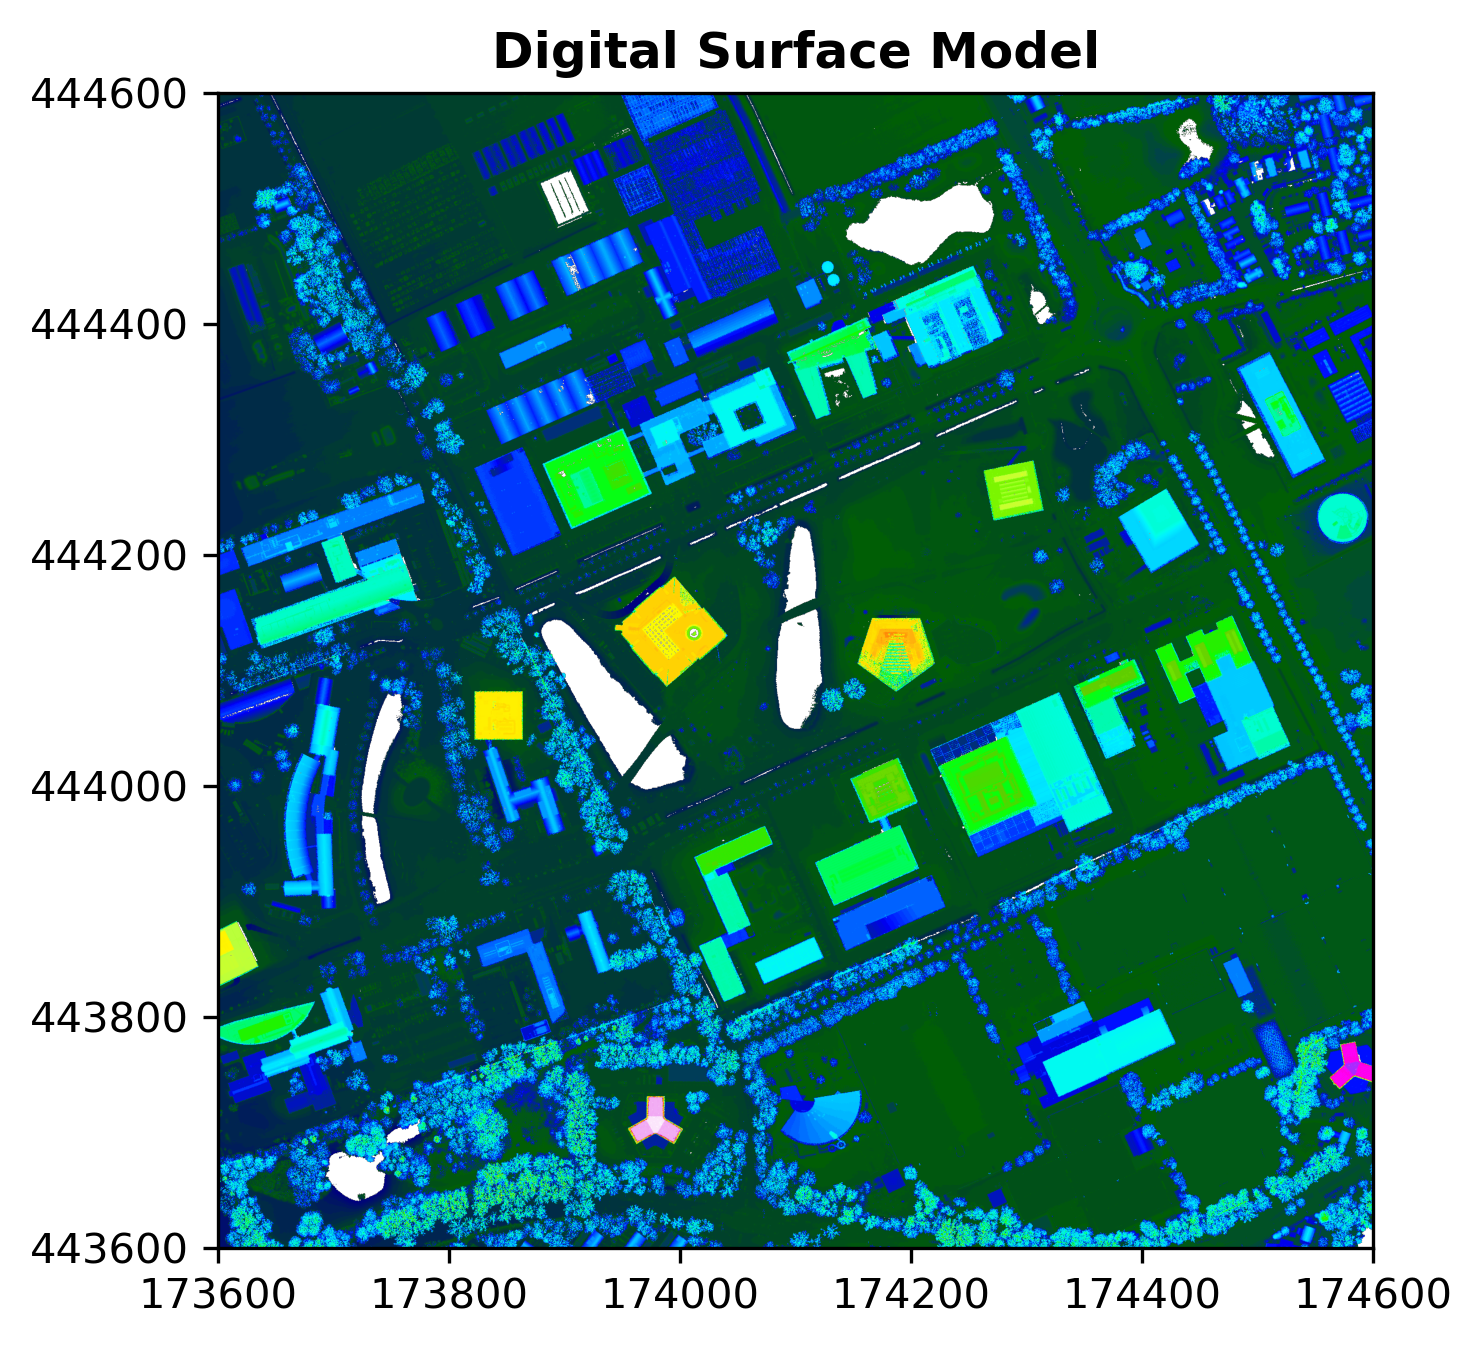

<Axes: title={'center': 'Digital Surface Model'}>

In [11]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the two rasters 
dsm = rasterio.open("data/AHN3_05m_DSM.tif", driver="GTiff")
dtm = rasterio.open("data/AHN3_05m_DTM.tif", driver="GTiff")

# Metadata functions from Rasterio
print(dsm.meta)
print(dtm.meta)

# Plot with rasterio.plot, which provides Matplotlib functionality
plt.figure(figsize=(5, 5), dpi=300)  # adjust size and resolution
show(dsm, title='Digital Surface Model', cmap='gist_ncar')

> **Question 2**: Adjust the code above to take a look at the DTM. Note the gaps that appear. What are these gaps?

*These are buildings.*

In [12]:
# Rasterio object
print(type(dsm))

# Read, show object type and data
dsm_data = dsm.read(1)
print(type(dsm_data))
print(dsm_data)

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
[[9.6194000e+00 9.6737003e+00 9.7122002e+00 ... 1.5386500e+01
  1.5427000e+01 1.5508700e+01]
 [9.7265997e+00 9.6819000e+00 9.6217003e+00 ... 1.5614400e+01
  1.5687100e+01 1.5700100e+01]
 [9.6140003e+00 9.5950003e+00 9.5971003e+00 ... 1.5810200e+01
  1.5840300e+01 1.5918300e+01]
 ...
 [8.1936998e+00 8.1719999e+00 8.1789999e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]
 [8.1758003e+00 8.1443005e+00 8.1541996e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]
 [8.1570997e+00 8.1427002e+00 8.1483002e+00 ... 3.4028235e+38
  3.4028235e+38 3.4028235e+38]]


# Processing raster data
## Creating a Canopy Height Model
A Canopy Height Model (CHM) gives an indication of the height of trees and/or buildings. It can be created by subtracting a Digital Terrain Model from a Digital Surface Model. In the resulting raster, each cell value represents the height above the underlying surface topography.

In [13]:
import numpy as np

# Access the data from the two rasters
dsm_data = dsm.read()
dtm_data = dtm.read()

# Set our nodata to np.nan (this is important for later)
dsm_data[dsm_data == dsm.nodata] = np.nan
dtm_data[dtm_data == dtm.nodata] = np.nan

Earlier, we noticed that the DTM included gaps. Let's first fill these gaps using the `fillnodata()` function from `rasterio.fill`. For more information, see the [documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.fill.html).

In [14]:
from rasterio.fill import fillnodata

# Create a mask to specify which pixels to fill (0=fill, 1=do not fill)
dtm_mask = dtm_data.copy()
dtm_mask[~np.isnan(dtm_data)] = 1
dtm_mask[np.isnan(dtm_data)] = 0

# Fill missing values
dtm_data = fillnodata(dtm_data, mask=dtm_mask)

Now, let's can create our CHM:

In [15]:
# Subtract the NumPy arrays 
chm = dsm_data - dtm_data

# Check the resulting array
print(chm)

# Copy metadata of one of the rasters (does not matter which one)
kwargs = dsm.meta 

# Save the chm as a raster
with rasterio.open('data/AHN3_05m_CHM.tif', 'w', **kwargs) as file:
    file.write(chm.astype(rasterio.float32))

[[[0.         0.0187006  0.00889969 ... 3.199545   3.244937   3.3275146 ]
  [0.02470016 0.02740002 0.         ... 3.435215   3.5135546  3.5329914 ]
  [0.         0.         0.         ... 3.6233873  3.6674585  3.7521896 ]
  ...
  [0.         0.         0.         ...        nan        nan        nan]
  [0.         0.         0.         ...        nan        nan        nan]
  [0.         0.         0.         ...        nan        nan        nan]]]


> **Question 3**: Where is the CHM the highest in the study area? Is it what you expected?

*Think about where you have the most forests on campus.*

We have now applied the basic concepts of creating a Canopy Height Model!

## Computing heights of buildings
Using our CHM, let's determine the average heights of the buildings in our study area. The first step is to download building data from the BAG Web Feature Service that we also used in the vector tutorial. Note that we make use of the `bbox` from an earlier codeblock for this.

In [16]:
import geopandas as gpd
import json
from owslib.wfs import WebFeatureService

# Get the WFS of the BAG
wfsUrl = 'https://service.pdok.nl/lv/bag/wfs/v2_0'
wfs = WebFeatureService(url=wfsUrl, version='2.0.0')
layer = list(wfs.contents)[0]

# Get the features for the study area
# notice that we now get them as json, in contrast to before
response = wfs.getfeature(typename=layer, bbox=bbox, outputFormat='json')
data = json.loads(response.read())

# Create GeoDataFrame, without saving first
buildings_gdf = gpd.GeoDataFrame.from_features(data['features'])

# Set crs to RD New
buildings_gdf.crs = 28992

In [17]:
import rasterstats as rs

# Apply the zonal statistics function with gdf and tif as input
chm_buildings = rs.zonal_stats(buildings_gdf, "data/AHN3_05m_CHM.tif", prefix='CHM_', geojson_out=True)

# Convert GeoJSON to GeoDataFrame
buildings_gdf = gpd.GeoDataFrame.from_features(chm_buildings)

# Check the added attributes with a prefix 'CHM_'
print(buildings_gdf['CHM_mean'])

0       4.877371
1       4.733384
2       0.649987
3       6.146636
4      11.102596
         ...    
170     0.272160
171     0.000000
172     9.180445
173     0.132247
174     2.511573
Name: CHM_mean, Length: 175, dtype: float64


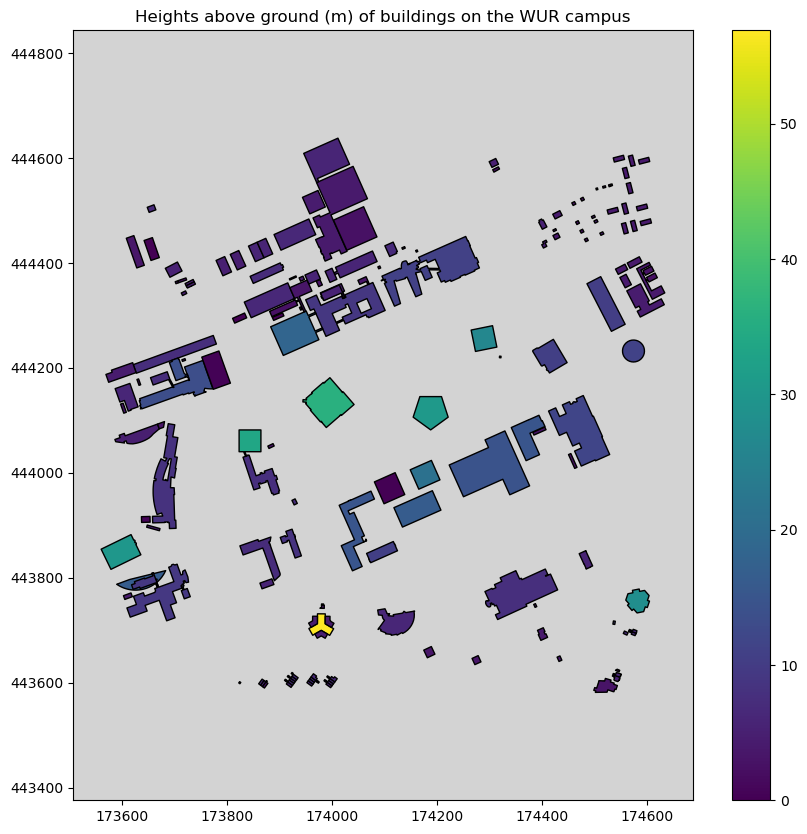

In [18]:
# Create one plot with figure size 10 by 10
fig, ax = plt.subplots(1, figsize=(10, 10))

# Customize figure with title, legend, and facecolour
ax.set_title('Heights above ground (m) of buildings on the WUR campus')
buildings_gdf.plot(ax=ax, column='CHM_mean', k=6,
                   cmap=plt.cm.viridis, linewidth=1, edgecolor='black', legend=True)
ax.set_facecolor("lightgray")

# Make sure to get an equal scale in the x and y direction
plt.axis('equal')

# Visualize figure
plt.show()

> **Question 4**: Why do we want an equal scale in the x and y direction for this figure?

*To visualize the buildings properly, otherwise their geometries will be skewed.*

## Other functionality
Note that this tutorial only scratches the surface of the possibilities of Rasterio. It can do most if not all things you did in `R` in the Vector - Raster tutorial. Rasterio for example also allows you to do [masking](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html), [reprojecting](https://rasterio.readthedocs.io/en/latest/topics/reproject.html), and [resampling](https://rasterio.readthedocs.io/en/latest/topics/resampling.html).

# More on writing raster data to a file
As you've seen before, to store the NumPy array as a raster file, Rasterio needs the accompanying metadata. It is possible to use the metadata of an existing raster (which we did before), but it is also possible to create it from scratch. 

To create metadata from scratch, the CRS can be defined with a function from Rasterio and the transformation can be defined using Affine. Affine is a Python module that facilitates [affine transformations](https://www.quora.com/In-an-intuitive-explanation-what-is-an-affine-transformation-of-image), i.e. scaling, rotating, mirroring or skewing of images/rasters/arrays.

Rasterio can write most [raster formats from GDAL](https://www.gdal.org/formats_list.html). [The developers recommend using GeoTiff driver](https://github.com/mapbox/rasterio/issues/731) for writing as it is the best-tested and best-supported format. 

In [19]:
import affine

# Specify the components of the crs (we know them from the DSM)
kwargs = {'driver': 'GTiff',
          'dtype': 'float32',
          'nodata': np.nan,
          'width': 2000,
          'height': 2000,
          'count': 1,
          'crs': rasterio.crs.CRS({'init': 'epsg:28992'}),
          'transform': affine.Affine(0.5, 0.0, 173600.0, 0.0, -0.5, 444600.0)}

# Write the raster file
with rasterio.open('data/AHN3_05m_CHM_affine.tif', 'w', **kwargs) as file:
    file.write(chm.astype(rasterio.float32))

# More on raster data visualization
Raster data can be visualized by passing NumPy arrays to Matplotlib directly or by making use of a method in Rasterio that accesses Matplotlib for you. Using Matplotlib directly allows more flexibility, such as tweaking the legend, axis and labels, and is more suitable for professional purposes. The visualization using Rasterio requires less code and can give a quick idea of your raster data. We show both approaches below. Let's first make a visualization of the DSM using Matplotlib:

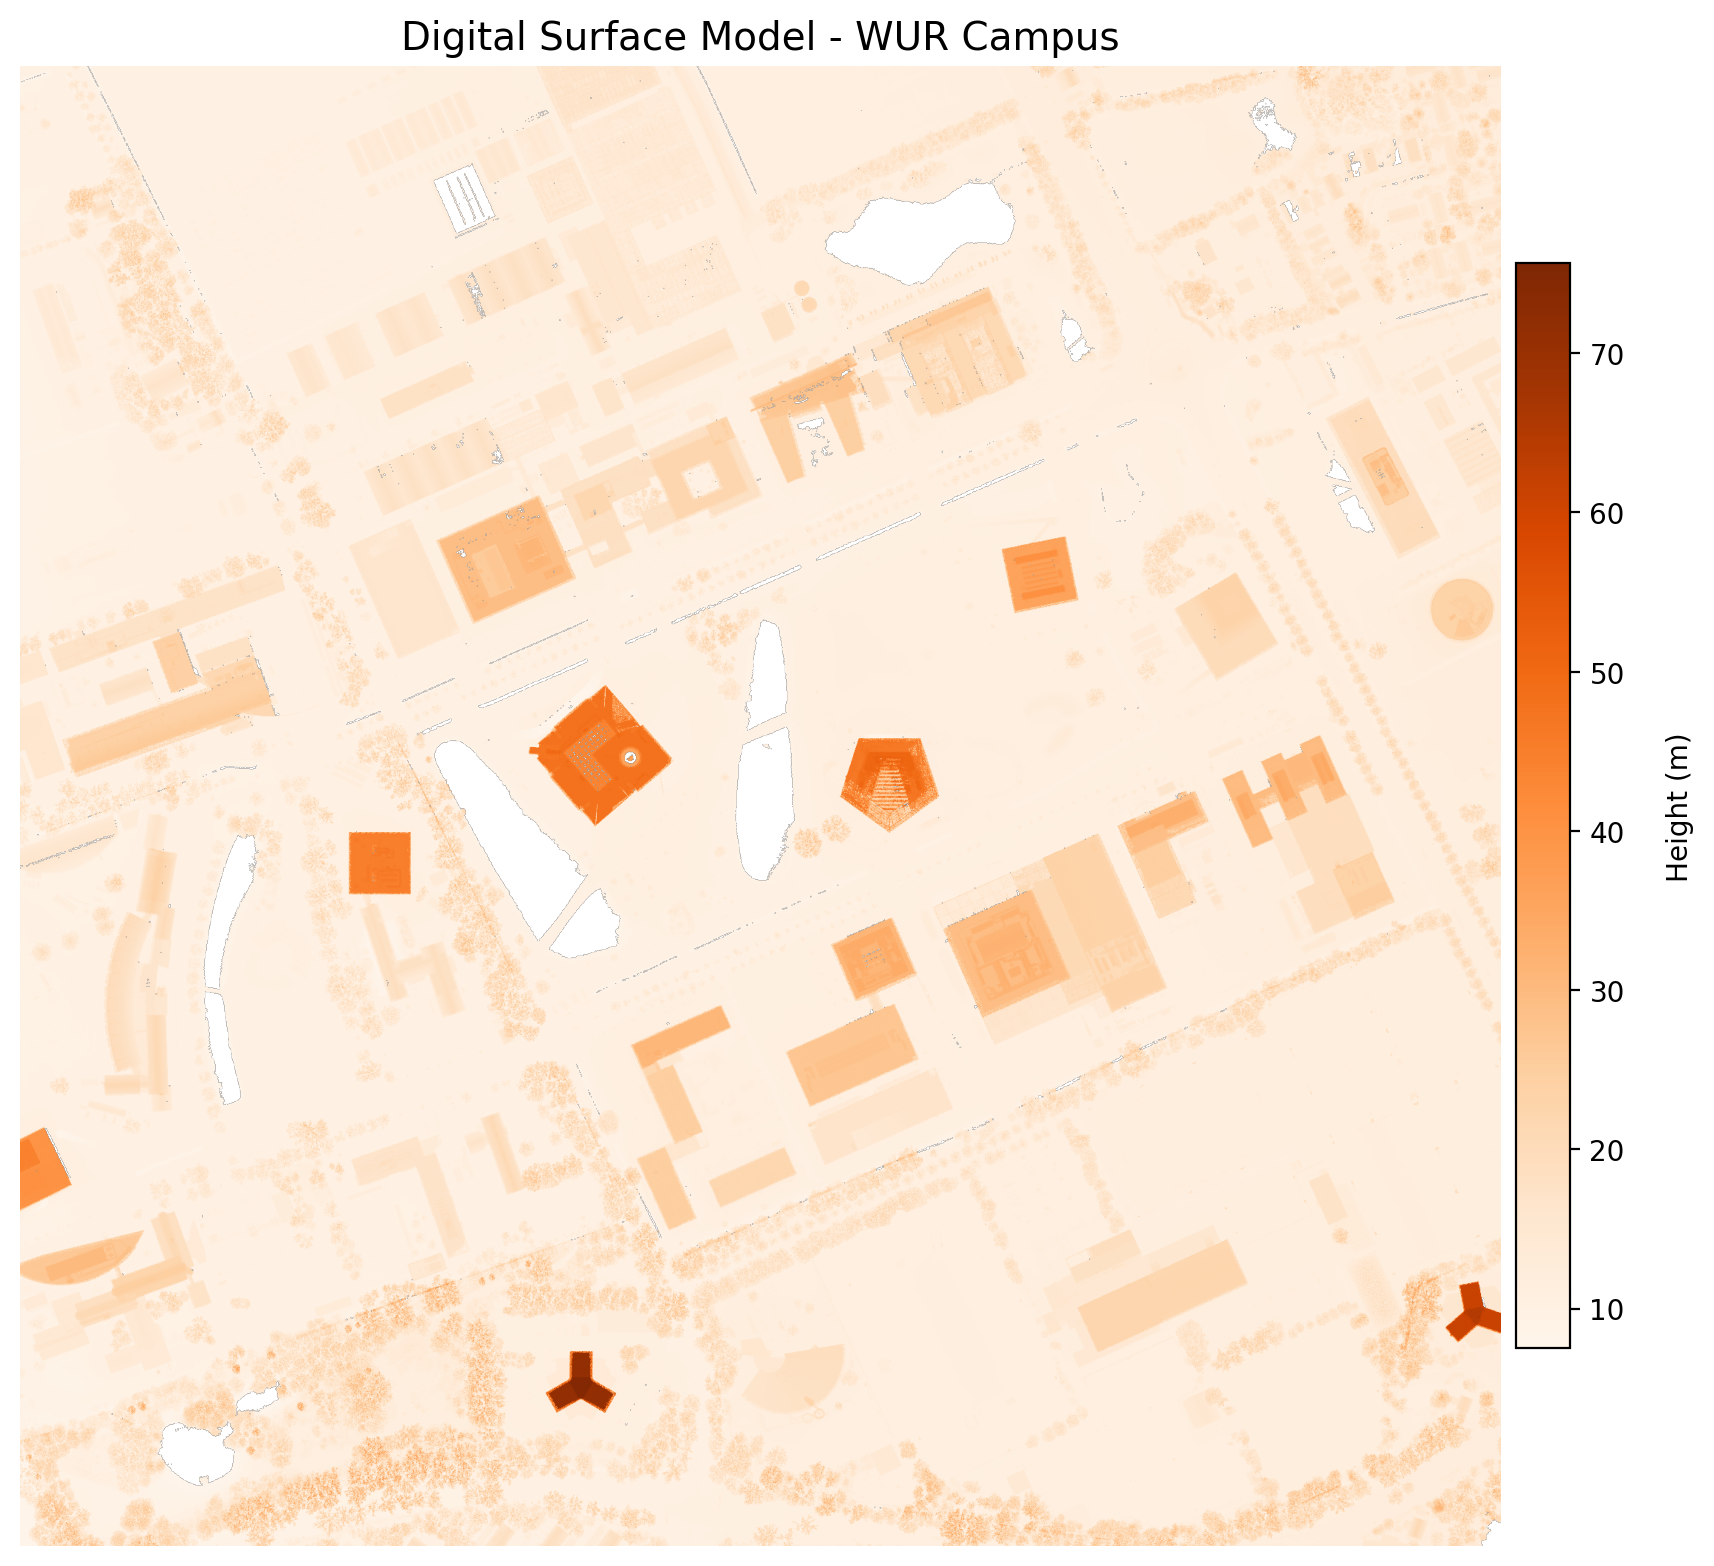

In [20]:
# Create one plot with figure size 10 by 10
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# imshow() is the main raster plotting method in Matplotlib
# Again, ensure an equal scale in the x and y direction
dsmplot = ax.imshow(dsm_data[0], cmap='Oranges', extent=bbox, aspect='equal')

# Title (do not do this for a scientific report, use a caption instead)
ax.set_title("Digital Surface Model - WUR Campus", fontsize=14)

# Add a legend (colourbar) with label
cbar = fig.colorbar(dsmplot, fraction=0.035, pad=0.01)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Height (m)', rotation=90)

# Hide the axes
ax.set_axis_off()
plt.show()

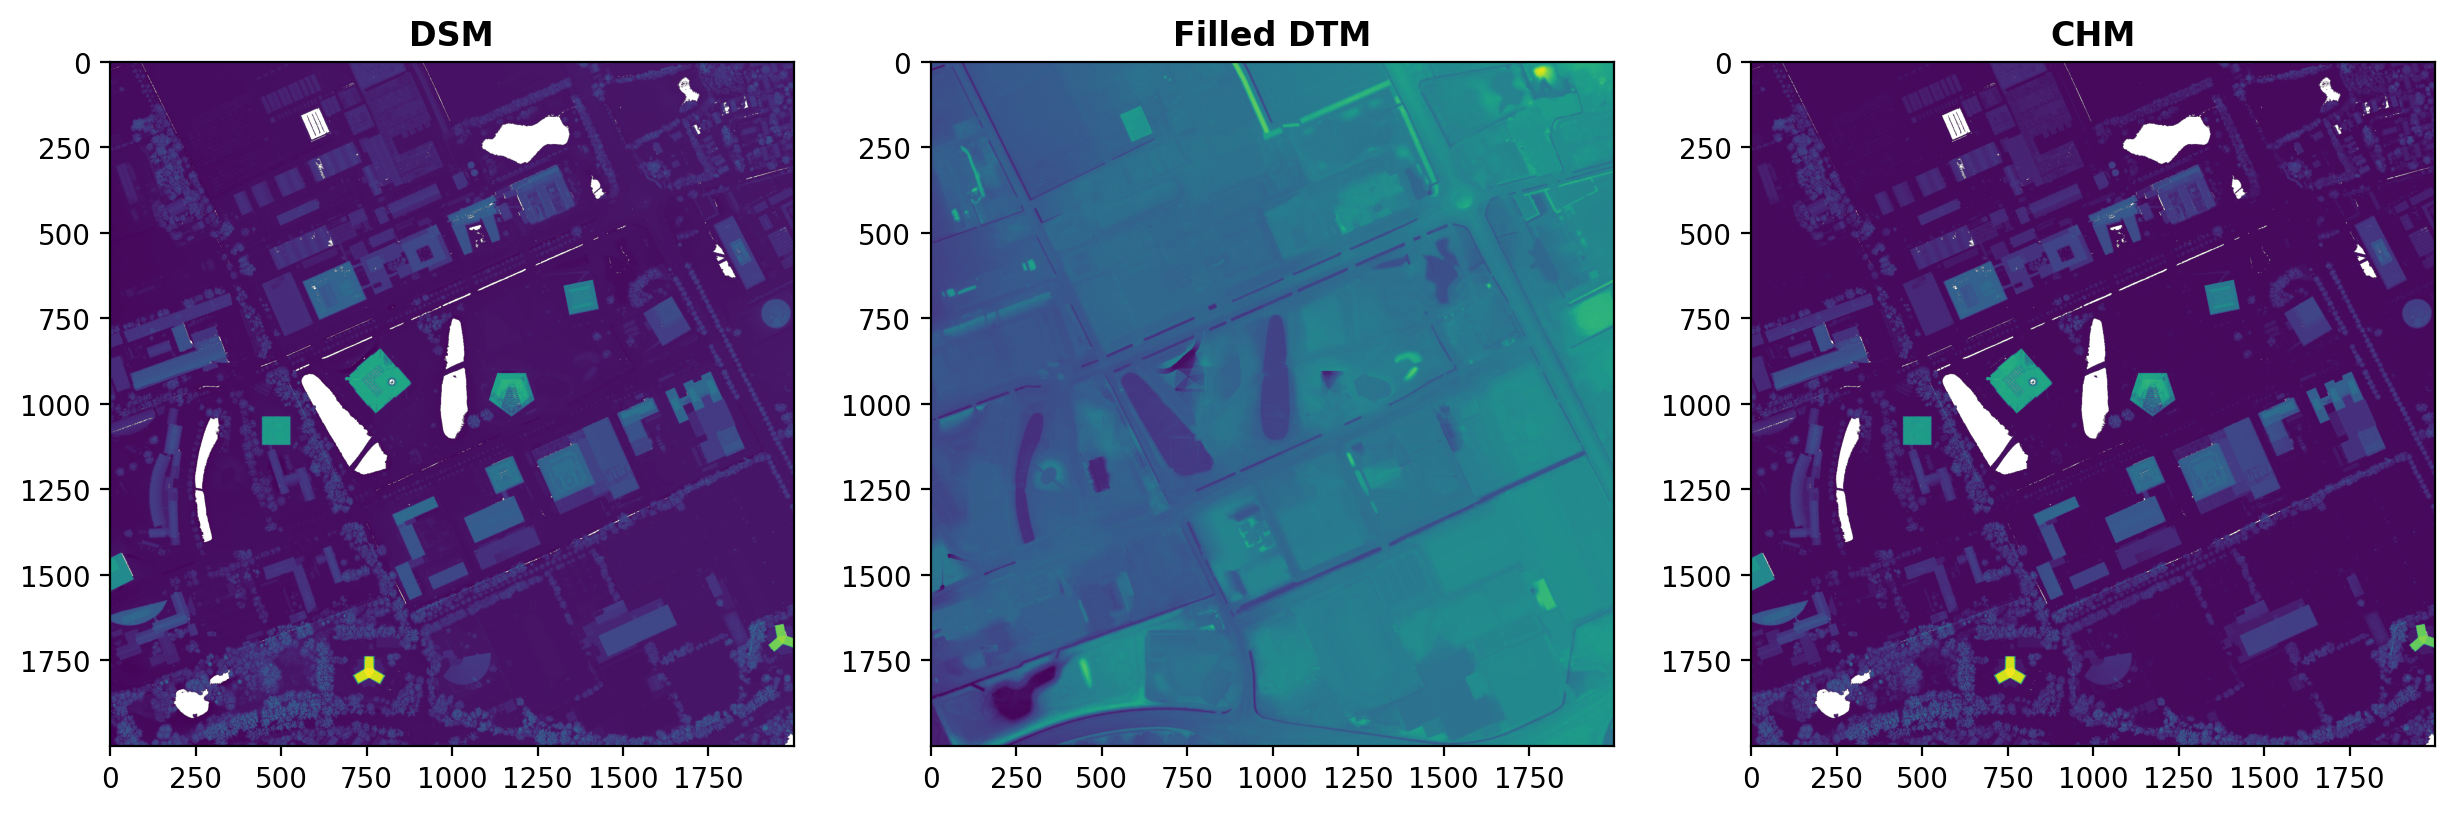

In [21]:
# Figure with three subplots, unpack directly
fig, (axdsm, axdtm, axchm) = plt.subplots(1, 3, figsize=(15, 7), dpi=200)

# Populate the three subplots with raster data
show(dsm_data, ax=axdsm, title='DSM')
show(dtm_data, ax=axdtm, title='Filled DTM')
show(chm, ax=axchm, title='CHM')
plt.show()

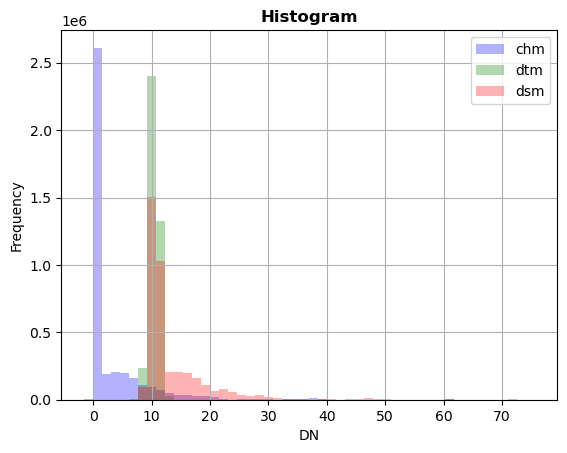

In [24]:
from rasterio.plot import show_hist

import numpy as np

# Stack the three arrays along a new axis to create a 3-band raster
# Ensure all arrays have the same shape and are 2D
three_band_array = np.stack([dsm_data, dtm_data, chm], axis=0).squeeze()

# Copy metadata and update for 3 bands
three_band_meta = dsm.meta.copy()
three_band_meta.update(count=3)

# Write the 3-band raster to file
with rasterio.open('data/AHN3_05m_3band.tif', 'w', **three_band_meta) as dst:
  dst.write(three_band_array.astype(rasterio.float32))

with rasterio.open('data/AHN3_05m_3band.tif') as raster:
  show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3, 
        histtype='stepfilled', title="Histogram", label = ['dsm', 'dtm', 'chm'])

> **Question 5**: What is represented on the x and y axis? The default axis labels are DN (x) and Frequency (y); if you were to change them, what labels would you pick to better reflect the content of the plots?

*The y axis represents the count of pixels. Meanwhile the x axis represents the pixel's DN (digital value), in this tutorial since we are looking at elevation this value is actually meters. For example, in the first plot (DSM) you can see that most pixel values are in the 10 to 15 meter range*

# More info
  * [Tutorial working with rasters in Python with Rasterio](https://geohackweek.github.io/raster/04-workingwithrasters/)
  * [Tutorial working with raster in Python with GDAL (for Python 2)](https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html)
  * [Landsat satellite images](https://earthexplorer.usgs.gov/)
  * [Resampled landsat satellite images](http://espa.cr.usgs.gov/index/)
  * [Sentinel satellite images](https://scihub.copernicus.eu/dhus/#/home)